In [1]:
import os
%matplotlib inline

song_file = os.path.join('assets', 'twinkle.mp3')

# https://electronics.stackexchange.com/questions/251157/can-i-use-the-fft-to-recognize-musical-notes-on-a-piano

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
from functools import partial

import audiosegment
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from moviepy.editor import *
from scipy.signal import find_peaks
from tqdm import tqdm

from signal_process_utils import generate_frequency_table


class Decomposer:

    def __init__(self, mp3_file, plot=False, debug=False):
        """
        Class to decompose an mp3 file into its frequency vs. time spectrogram, and map that to piano keys.
        Args:
            mp3_file (str): name of mp3 file to process.
            plot (bool): for debugging.
            debug (bool): for debugging.
        """
        self.mp3_file = mp3_file
        self.plot = plot
        self.debug = debug

        # audio/acoustic data
        self.seg = audiosegment.from_file(mp3_file)
        self.raw_samples = np.array(self.seg.seg.get_array_of_samples())
        self.freq_table = generate_frequency_table()

        # other useful values
        self.in_sample_rate = self.seg.frame_rate
        self.num_samples = len(self.raw_samples)
        self.ms = len(self.seg)
        self.max_freq = 4186  # hz of high c (key 88)

        # useful transform for better plotting visualization of spectrogram
        self._log_amps = lambda x: 10 * np.log10(x + 1e-9)

        def _find_nearest(value, array):
            """Quantize a value (detected frequency) to piano nearest frequency."""
            idx = np.argmin(np.abs(array - value))
            return 89 - idx

        self._map_freq2note = np.vectorize(partial(_find_nearest, array=self.freq_table['Frequency (Hz)'].values))

    def cvt_mp3_to_piano(self):
        self._generate_spectrogram()
        self._parse_spectrogram()
        self._build_movie()

    @staticmethod
    def _median_filter(arr, length=5, stride=1):
        """Compute the 1D median filter of an array. This helps remove outliers and noise.

        Args:
            arr (np.ndarray): arr to filter
            length (int): window size
            stride (int): step size

        Returns:
            smoothed np.ndarray
        """
        nrows = ((arr.size - length) // stride) + 1
        n = arr.strides[0]
        windowed_matrix = np.lib.stride_tricks.as_strided(arr, shape=(nrows, length), strides=(stride * n, n))
        median = np.median(windowed_matrix, axis=1)
        arr[-median.shape[0]:] = median
        return arr

    def _generate_spectrogram(self, window_length_s=0.5, overlap=0.9):
        """ Generate a spectrogram from our mp3 data."""
        self.freqs, self.times, self.amplitudes = self.seg.spectrogram(window_length_s=window_length_s,
                                                                       overlap=overlap)
        # slice out only the ranges we are interested in
        max_freq_idx = np.argmin(self.freqs < self.max_freq)
        self.times = self.times / 2
        self.freqs = self.freqs[:max_freq_idx]
        self.amplitudes = self.amplitudes[:max_freq_idx, :]

        # median filter along time axis to get rid of white noise
        self.amplitudes = np.apply_along_axis(self._median_filter, 1, self.amplitudes)

        self._plot_spectrogram(self.amplitudes, 'Raw Spectrogram')

    def _parse_spectrogram(self):
        """ Parse the spectrogram by iterating through the time axis, thresholding
        away quiet frequencies, and mapping the dominant frequencies to piano keys."""

        def _get_peaks_and_threshold(t):
            """ Given a time(t), extract the dominant frequencies in the amplitude
            matrix using argrelextrema, and threshold all other values to zero the
            values a new matrix, self.dominant_amplitudes. Thresholding performed by
            selecting the inverse indices of the detected peaks.
            """

            # peak detection in a amplitude vector at time t
            # take log of vec since amplitudes decay exponentially at higher freqs
            # https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy/52612432#52612432
            peaks_idx = find_peaks(np.log(self.amplitudes[:, t]), prominence=3)[0]

            # select inverse indices of peaks, threshold to zero
            arr = self.dominant_amplitudes[:, t]
            ia = np.indices(arr.shape)
            not_indices = np.setxor1d(ia, peaks_idx)
            arr[not_indices] = 0
            self.dominant_amplitudes[:, t] = arr

        def _get_notes(t):
            """ Map the dominant frequencies at time(t) to the corresponding piano keys.

            If we detect a frequency in self.dominant_amplitudes, quantize that frequency into
            one of the piano frequency bins, store in array detected_freqs, and get the piano note
            index using self._map_freq2note."""

            # if dominant frequency vector is non-zero, map all detected freqs to notes
            amp_arr = self.dominant_amplitudes[:, t]
            if np.count_nonzero(amp_arr) != 0:
                freq_idx = np.nonzero(amp_arr)[0]
                amp_arr_nonzero = amp_arr[freq_idx]
                detected_freqs = self.freqs[freq_idx]
                f_table_idx = self._map_freq2note(detected_freqs)

                if self.debug:
                    # bc dataframes are prettier than matrices
                    helmholtz = self.freq_table.ix[90 - f_table_idx].Helmholtzname
                    notes_out = pd.DataFrame([
                        helmholtz.values,
                        detected_freqs,
                        amp_arr_nonzero,
                        f_table_idx]
                    ).T
                    notes_out.columns = ['note', 'f', 'db', 'num']
                    print(notes_out)

                return f_table_idx, amp_arr_nonzero
            return None, None

        # init keyboard frames with predefined shape - will eventuall turn to video
        keyboard_img_size = [self.times.shape[0]] + [232, 1910, 3]
        self.keyboard_frames = np.empty(keyboard_img_size)

        # init dom freqs matrix, iterate through time, find peaks and threshold
        self.dominant_amplitudes = self.amplitudes.copy()
        for t in tqdm(range(self.times.shape[0])):
            _get_peaks_and_threshold(t)
        print('[Decomposer] >>>> Found dominant frequencies.')

        # median filter along time axis to get rid of white noise
        self.dominant_amplitudes = np.apply_along_axis(self._median_filter, 1, self.dominant_amplitudes)

        # iterate through time, map dominant frequencies to notes, generate keyboard visualizations
        for t in tqdm(range(self.times.shape[0])):
            t_note_data = _get_notes(t)
            keyboard = self._generate_keyboard(*t_note_data)
            self.keyboard_frames[t, ...] = keyboard
        print('[Decomposer] >>>> Mapped frequencies to notes and generated keyboard visualizations.')

        self._plot_spectrogram(self.dominant_amplitudes, 'Filtered Spectrogram of Dominant Frequencies')

    def _generate_keyboard(self, f_table_idx, amp_arr_nonzero):
        """
        Iterate through notes found in sample and draw on keyboard image.
        Intensity of color depends on loudness (decibels).
        All detected notes are stacked into a single image.

        Args:
            f_table_idx (np.ndarray): indices of active notes in self.freq_table.
            amp_arr_nonzero (np.ndarray): vector containing raw amplitude values
        Returns:
            np.array image of colorized piano

        """
        # init a fresh piano img
        piano_img = os.path.join('assets', 'piano.jpg')
        piano_template = cv2.cvtColor(cv2.imread(piano_img), cv2.COLOR_BGR2RGB)

        if f_table_idx is not None:
            amp_arr_nonzero /= np.max(amp_arr_nonzero)  # normalize vector [0, 1]

            # iterate through detected notes, extract location on keyboard
            for n in range(f_table_idx.shape[0]):
                idx = f_table_idx[n]
                loudness = amp_arr_nonzero[n]
                freq_map = self.freq_table.ix[90 - idx]
                if type(freq_map.points) is not list: continue  # handle nan cases

                # color in detected note on keyboard img, stack onto output img
                piano = piano_template.copy()
                points = np.array(freq_map.points, dtype=np.int32)
                cv2.fillPoly(piano, [points[:, ::-1]], [0, 255, 0])
                piano_template = cv2.addWeighted(piano_template, 1 - loudness, piano, loudness, 0)
        return piano_template

    def _plot_spectrogram(self, amplitude_matrix, title=''):
        """ Plot our spectrograms. """
        if self.plot:
            plt.figure(figsize=(20, 6))
            plt.pcolormesh(self.times, self.freqs, self._log_amps(amplitude_matrix))
            plt.xlabel("Time in Seconds")
            plt.ylabel("Frequency in Hz")
            plt.title(title)
            plt.show()

    def _build_movie(self):
        """ Concatenate self.keyboard_frames images into video file, add back original music."""
        frames = []
        duration = self.times[1] - self.times[0]

        for i in tqdm(range(self.keyboard_frames.shape[0])):
            piano_img = self.keyboard_frames[i, ...]
            single_frame = ImageClip(piano_img).set_duration(duration)
            frames.append(single_frame)
        out = concatenate_videoclips(frames, method="compose")
        out = out.set_audio(AudioFileClip(self.mp3_file))

        # use temp audio to deal with moviepy bug
        outfile = self.mp3_file.replace('assets', 'output')
        outfile = outfile.replace('mp3', 'mp4')
        out.write_videofile(outfile,
                            fps=30,
                            temp_audiofile="temp-audio.m4a",
                            remove_temp=True,
                            codec="libx264",
                            audio_codec="aac"
                            )


In [3]:
self = Decomposer(song_file, True, False)

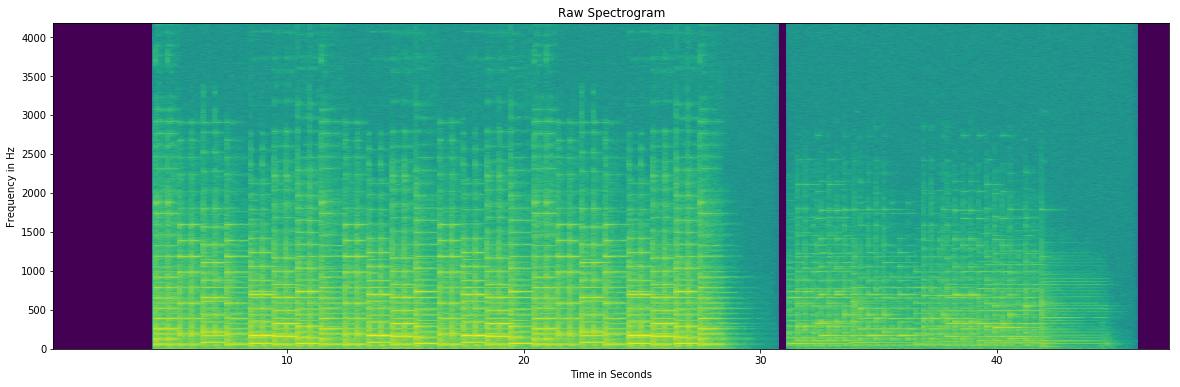

In [4]:
self._generate_spectrogram()

In [5]:
self._parse_spectrogram()

100%|██████████| 1888/1888 [00:00<00:00, 2932.07it/s]


[Decomposer] >>>> Found dominant frequencies.


 21%|██        | 401/1888 [00:09<00:36, 40.74it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/mnalavadi/anaconda3/envs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-98e94cab56da>", line 1, in <module>
    self._parse_spectrogram()
  File "<ipython-input-2-a35d9ef3d794>", line 160, in _parse_spectrogram
    keyboard = self._generate_keyboard(*t_note_data)
  File "<ipython-input-2-a35d9ef3d794>", line 190, in _generate_keyboard
    freq_map = self.freq_table.ix[90 - idx]
  File "/Users/mnalavadi/anaconda3/envs/cv/lib/python3.6/site-packages/pandas/core/indexing.py", line 122, in __getitem__
    return self._getitem_axis(key, axis=axis)
  File "/Users/mnalavadi/anaconda3/envs/cv/lib/python3.6/site-packages/pandas/core/indexing.py", line 1116, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/Users/mnalavadi/anaconda3/envs/cv/lib/python3.6/site-packages/pandas/core/indexing.py", line 140, in _g

KeyboardInterrupt: 

In [ ]:
self._build_movie()

In [ ]:
# from scipy.signal import find_peaks
# for t in range(200): #range(self.times.shape[0]):
#     amp_arr = self.amplitudes[:, t]
#     if not np.sum(amp_arr) == 0*len(amp_arr):
#         log_amp_arr = np.log(amp_arr)
#         peaks_idx = find_peaks(log_amp_arr, prominence=3)[0]
#         print(peaks_idx)
#         amp_arr[peaks_idx]
#         plt.figure(figsize=(20, 4))
#         plt.plot(range(len(amp_arr)), amp_arr)
#         plt.scatter(peaks_idx, amp_arr[peaks_idx], s=12, c='r')
#         plt.show()